In [2]:
# Useful packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sage
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

# Generating the dataset
We take the led dataset and add noise to it to introduce randomness and compare between train and test sets.

In [3]:
def make_noised_led_sample(
    n_samples=200, irrelevant=0, flip_proba=0.1, random_state=None
):
    random_state = check_random_state(random_state)

    data = np.array(
        [
            [0, 0, 1, 0, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 2],
            [1, 0, 1, 1, 0, 1, 1, 3],
            [0, 1, 1, 1, 0, 1, 0, 4],
            [1, 1, 0, 1, 0, 1, 1, 5],
            [1, 1, 0, 1, 1, 1, 1, 6],
            [1, 0, 1, 0, 0, 1, 0, 7],
            [1, 1, 1, 1, 1, 1, 1, 8],
            [1, 1, 1, 1, 0, 1, 1, 9],
            [1, 1, 1, 0, 1, 1, 1, 0],
        ]
    )

    data = data[random_state.randint(0, 10, n_samples)]
    X, y = np.array(data[:, :7], dtype=np.intp), data[:, 7]
    X_noised = np.zeros_like(X)
    for sample in range(n_samples):
        X_noised[sample, :] = np.abs(
            random_state.binomial(n=1, p=flip_proba, size=7) - X[sample, :]
        )
    if irrelevant > 0:
        X_noised = np.hstack((X_noised, random_state.rand(n_samples, irrelevant) > 0.5))
    return X_noised, y


# Compare asymptotics of MDI and UMDI

In [4]:
n_rep = 5
flip_proba = 0.1
max_n_sample = 1e4
n_estimators = 100
train_sizes_large = np.logspace(start=2, stop=np.log10(max_n_sample), base=10, num=10, dtype=np.intp)


In [5]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7"]
mdi_all = np.zeros((len(feature_names), len(train_sizes_large), n_rep))
umdi_all = np.zeros((len(feature_names), len(train_sizes_large), n_rep))

for t_idx, n_samples in enumerate(train_sizes_large):
    for rep in range(n_rep):
        X, y = make_noised_led_sample(
            n_samples=n_samples, flip_proba=flip_proba, random_state=rep
        )
        X = X.astype(np.float32)
        model = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=1,
            max_depth=None,
            n_jobs=-1,
            random_state=rep,
        )
        model.fit(X, y)        
        mdi_all[:, t_idx, rep] = model.feature_importances_
        
        model = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=1,
            max_depth=None,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=rep,
        )
        model.fit(X, y)
        umdi = model.unbiased_feature_importances_
        umdi_all[:, t_idx, rep] = umdi/umdi.sum()
        # print(model.oob_score_)

In [6]:
# Compute shapley values
sage_values = []
n_samples = 10000
for rep in range(n_rep):
    X, y = make_noised_led_sample(
        n_samples=n_samples, flip_proba=flip_proba, random_state=rep
    )

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=500, random_state=rep)
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=1,
        max_depth=None,
        n_jobs=-1,
        random_state=rep,
    )
    model.fit(X, y)

    imputer = sage.MarginalImputer(model, X[:1000])
    estimator = sage.PermutationEstimator(
        imputer, "cross entropy", random_state=rep
    )
    sage_value = estimator(X[:1000,:], y[:1000]).values
    sage_values.append(sage_value)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# Plot the evolution of the norm of the difference

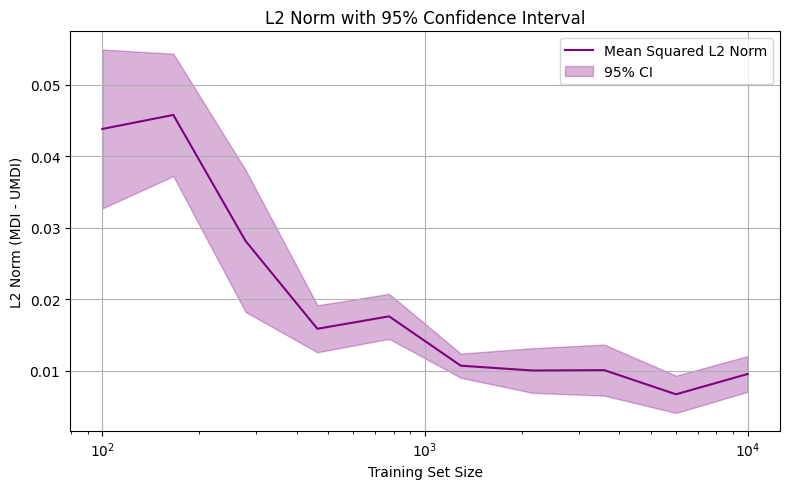

In [7]:
l2_mean = []
l2_sem = []

for t_idx in range(len(train_sizes_large)):
    mdi_vals = mdi_all[:, t_idx, :]
    umdi_vals = umdi_all[:, t_idx, :]

    l2_squared = np.sqrt(np.sum((mdi_vals - umdi_vals) ** 2, axis=0))
    l2_mean.append(l2_squared.mean())
    l2_sem.append(l2_squared.std(ddof=1) / np.sqrt(n_rep))

l2_mean = np.array(l2_mean)
l2_sem = np.array(l2_sem)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes_large, l2_mean, label='Mean Squared L2 Norm', color='purple')
plt.fill_between(
    train_sizes_large,
    l2_mean - 1.96 * l2_sem,
    l2_mean + 1.96 * l2_sem,
    color='purple',
    alpha=0.3,
    label='95% CI'
)

plt.xscale('log')
plt.xlabel('Training Set Size')
plt.ylabel('L2 Norm (MDI - UMDI)')
plt.title('L2 Norm with 95% Confidence Interval')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Compute FI as a decomposition of mutual information

In [8]:
from collections import Counter
import itertools
import math

def conditional_mutual_information(X, y, m, S):
    n_samples = X.shape[0]
    counter = Counter()

    # Build joint frequency tables
    for i in range(n_samples):
        x_m = X[i, m]
        s_vals = tuple(X[i, S]) if len(S) > 0 else ()
        y_val = y[i]
        counter[('xmys', x_m, y_val, s_vals)] += 1
        counter[('xms', x_m, s_vals)] += 1
        counter[('ys', y_val, s_vals)] += 1
        counter[('s', s_vals)] += 1

    cmi = 0.0
    for key_tuple, p_joint_count in counter.items():
        key = key_tuple[0]
        if key != 'xmys':
            continue
        _, x_m, y_val, s_vals = key_tuple
        p_xyz = p_joint_count / n_samples
        p_xz = counter[('xms', x_m, s_vals)] / n_samples
        p_yz = counter[('ys', y_val, s_vals)] / n_samples
        p_z = counter[('s', s_vals)] / n_samples


        # Avoid division by zero
        if p_xyz > 0 and p_xz > 0 and p_yz > 0 and p_z > 0:
            cmi += p_xyz * np.log(p_xyz * p_z / (p_xz * p_yz))

    return cmi

def compute_importance_theoric(X, y, m):
    p = X.shape[1]
    V_minus_m = [i for i in range(p) if i != m]
    total_importance = 0.0

    for k in range(p):
        subsets = list(itertools.combinations(V_minus_m, k))
        cmi_sum = 0.0

        for B in subsets:
            cmi = conditional_mutual_information(X, y, m, list(B))
            cmi_sum += cmi

        num_subsets = len(subsets)
        if num_subsets > 0:
            weight = 1.0 / (math.comb(p, k) * (p - k))
            total_importance += weight * cmi_sum  

    return total_importance


In [9]:
# n_rep = 5
# theoretical_value = []
# for rep in range(n_rep):
#     X, y = make_noised_led_sample(n_samples=int(max_n_sample), flip_proba=flip_proba, random_state=rep)
#     imp = np.array([compute_importance_theoric(X, y, m) for m in range(7)])
#     theoretical_value.append(imp/imp.sum())

# np.mean(theoretical_value, axis=0)

In [10]:
from collections import defaultdict
def conditional_variance_gini(X, y, m, S):
    """
    Compute conditional variance for Gini impurity: Var(Y|S) - Var(Y|X_m, S)
    
    For categorical Y, this uses the variance of class probabilities.
    """
    n_samples = X.shape[0]
    
    # Convert y to class indices if needed
    if y.ndim > 1:
        y = np.argmax(y, axis=1)
    
    classes = np.unique(y)
    n_classes = len(classes)
    
    # Build conditioning contexts
    contexts_s = defaultdict(list)
    contexts_sm = defaultdict(list)
    
    for i in range(n_samples):
        s_vals = tuple(X[i, S]) if len(S) > 0 else ()
        sm_vals = tuple(X[i, S + [m]]) if len(S) > 0 else (X[i, m],)
        
        contexts_s[s_vals].append(y[i])
        contexts_sm[sm_vals].append(y[i])
    
    # Compute Var(Y|S) - weighted average of Gini impurities
    var_given_s = 0.0
    for s_vals, y_subset in contexts_s.items():
        weight = len(y_subset) / n_samples
        
        # Compute Gini impurity for this context
        class_counts = np.bincount(y_subset, minlength=n_classes)
        class_probs = class_counts / len(y_subset)
        gini_impurity = 1.0 - np.sum(class_probs ** 2)
        
        var_given_s += weight * gini_impurity
    
    # Compute Var(Y|S, X_m)
    var_given_sm = 0.0
    for sm_vals, y_subset in contexts_sm.items():
        weight = len(y_subset) / n_samples
        
        # Compute Gini impurity for this context
        class_counts = np.bincount(y_subset, minlength=n_classes)
        class_probs = class_counts / len(y_subset)
        gini_impurity = 1.0 - np.sum(class_probs ** 2)
        
        var_given_sm += weight * gini_impurity
    
    return var_given_s - var_given_sm

def shapley_conditional_variance(X, y, m):
    """
    Compute Shapley value using conditional variance.
    """
    p = X.shape[1]
    V_minus_m = [i for i in range(p) if i != m]
    total_importance = 0.0
    
    # Iterate over all possible subsets of features excluding m
    for k in range(p):
        subsets = list(itertools.combinations(V_minus_m, k))
        
        for S in subsets:
            # Marginal contribution of feature m given subset S
            marginal_contrib = conditional_variance_gini(X, y, m, list(S))
            
            # Shapley weight for this subset
            weight = math.factorial(k) * math.factorial(p - k - 1) / math.factorial(p)
            
            total_importance += weight * marginal_contrib
    
    return total_importance


In [11]:
n_rep = 5
theoretical_value = []
for rep in range(n_rep):
    X, y = make_noised_led_sample(n_samples=int(max_n_sample), flip_proba=flip_proba, random_state=rep)
    imp = np.array([shapley_conditional_variance(X, y, m) for m in range(7)])
    theoretical_value.append(imp/imp.sum())

np.mean(theoretical_value, axis=0)

array([0.13641844, 0.17339359, 0.14507146, 0.16694555, 0.18604595,
       0.07532183, 0.11680318])

# Plot evolution as a heatmap and compare with SAGE

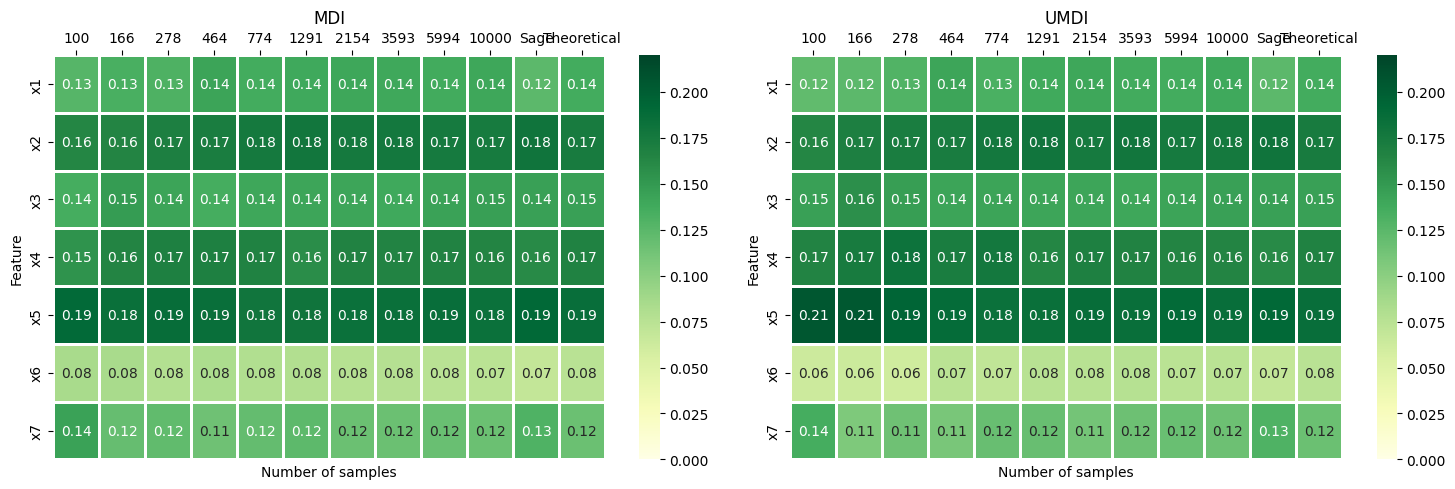

In [ ]:
MDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
UMDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for t_idx in range(len(train_sizes_large)):
    MDI_asymptotic.loc[:,f"{train_sizes_large[t_idx]}"] = np.mean(mdi_all[:, t_idx, :], axis=1)
    UMDI_asymptotic.loc[:,f"{train_sizes_large[t_idx]}"] = np.mean(umdi_all[:, t_idx, :], axis=1)

UMDI_asymptotic.loc[:, "Sage"] = np.mean(np.array(sage_values)/np.sum(sage_values, axis=1).repeat(7).reshape(5, 7), axis=0)
MDI_asymptotic.loc[:, "Sage"] = np.mean(np.array(sage_values)/np.sum(sage_values, axis=1).repeat(7).reshape(5, 7), axis=0)
UMDI_asymptotic.loc[:, "Theoretical"] = np.mean(theoretical_value, axis=0)
MDI_asymptotic.loc[:, "Theoretical"] = np.mean(theoretical_value, axis=0)

# Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(
    MDI_asymptotic,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[0],
    vmin=0,
    vmax=0.22,
)
axes[0].xaxis.tick_top()
axes[0].set_xlabel("Number of samples")
axes[0].set_ylabel("Feature")
axes[0].set_title("MDI")

sns.heatmap(
    UMDI_asymptotic,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[1],
    vmin=0,
    vmax=0.22,
)
axes[1].xaxis.tick_top()
axes[1].set_xlabel("Number of samples")
axes[1].set_ylabel("Feature")
axes[1].set_title("UMDI")

plt.tight_layout()
plt.show()